# Modelos de Machine Learning 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import joblib


from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

from sklearn import set_config; set_config(display='diagram')

## Importamos el Dataset

In [3]:
def simple_spam(s):
    text=word_tokenize(s)
    for index in range(len(text)-1):    
        if text[index]==text[index+1]:
            text[index]=''
        s=' '.join(w for w in text if w != '')
    return s

def double_spam(s):
    text=word_tokenize(s)
    for index in range(len(text)-3):    
        if text[index]+' '+text[index+1]==text[index+2]+' '+text[index+3]:
            text[index]=''
            text[index+1]=''
        s=' '.join(w for w in text if w != '').strip()
    return s

In [4]:
def spam(s):
    text=word_tokenize(s)
    for index in range(len(text)-1):    
        if text[index]==text[index+1]:
            text[index]=''
        text= [w for w in text if w != '']
        
    for index in range(len(text)-3):    
        if text[index]+' '+text[index+1]==text[index+2]+' '+text[index+3]:
            text[index]=''
            text[index+1]=''
        s=' '.join(w for w in text if w != '').strip()
    return s

In [5]:
df_lem = pd.read_csv('../../cyberbullying/data/lem_all_df.csv')
df_lem.head()

,text,target
0,one make analogy mathematical terms envisionin...,0.0
1,clarification zundark right checked wikipedia ...,0.0
2,elected electoral jhk,0.0
3,fun entry devotchka coworker korea tell differ...,0.0
4,please relate ozone hole increases cancer prov...,0.0


In [6]:
df_lem.shape

(226497, 2)

In [7]:
#from nltk.tokenize import word_tokenize

In [8]:
#df_lem['text'] = df_lem['text'].map(simple_spam)

In [9]:
#df_lem['text'] = df_lem['text'].map(double_spam)

## Distribución

In [10]:
def plot_dist(df):
    plt.figure(figsize = (7,7))
    sorted_counts = df['target'].value_counts()
    plt.pie(sorted_counts, labels = ['not bullying', 'bullying'], startangle = 90, counterclock = False,
            wedgeprops = {'width' : 0.6}, autopct='%1.1f%%', pctdistance = 0.7,
            textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
            colors = sns.color_palette("Paired")[7:])
    plt.text(x = -0.35, y = 0, s = f'Total comments: {df.shape[0]}')
    plt.title('Distribution of Comments in the Dataset', fontsize = 16);

In [11]:
percentage_used = 1
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

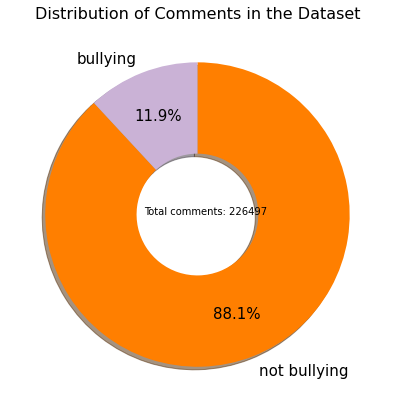

In [12]:
plot_dist(df_sample)

## Holdout

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['target'], test_size=0.3, random_state=0)

In [14]:
X_train = pd.DataFrame(data=X_train, columns=['text'])
X_test = pd.DataFrame(data=X_test, columns=['text'])

In [15]:
def balance_df(X, y, ratio=0.3):
    df = pd.DataFrame({'text': X, 'target': y})
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    df_class_1_len = df_class_1.shape[0]
    
    df_class_0_new = df_class_0.sample(int(df_class_1_len * (1-ratio)/ratio))
    df_new = pd.concat([df_class_0_new, df_class_1]).sample(frac=1).reset_index(drop=True)
    
    X = df_new['text']
    y = df_new['target']

    return X, y

#X_train, y_train = balance_df(X_train, y_train, ratio=0.1)
# no lo usamos

In [16]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scorer = make_scorer(f1_score)

In [17]:
def scores(cv_results):
    score_results = {'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
    for key in score_results.keys():
        if key == 'time':
            score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
        else:
            score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
    return score_results

In [18]:
def conf_mx_all(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1= np.round((2*precision*recall)/(precision+recall), 3)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {F1}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot();
    
    return recall, precision, accuracy, F1

In [19]:
def pipeline(vectorizer_list, learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    def list_params(new_class):
        name = new_class.__class__.__name__
        default_class = eval(name + '()').get_params()
        new_class = new_class.get_params()

        new_dict = {}

        for key in new_class.keys():
            if new_class[key] != default_class[key]:
                new_dict[key] = new_class[key]
        return new_dict
    
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for vectorizer in vectorizer_list:
        
        X_train_vec = vectorizer.fit_transform(X_train['text'])
        X_test_vec = vectorizer.transform(X_test['text'])
        
    
        for learner in learner_list:

            # Store the vectorizer name and params:
            results['Vectorizer'] = vectorizer.__class__.__name__
            results['Vectorizer Params'] = list_params(vectorizer)

            # Store the learner name and params:
            results['Algorithm'] = learner.__class__.__name__
            results['Algorithm Params'] = list_params(learner)

            # Fit the learner:
            start = time() # Get start time
            learner = learner.fit(X_train_vec, y_train)
            end = time() # Get end time

            # Store the training time
            results['Training Time'] = round(end - start, 2)

            start = time() # Get start time
            predictions_test = learner.predict(X_test_vec)
            predictions_train = learner.predict(X_train_vec)
            end = time() # Get end time

            # Store the prediction time
            results['Prediction Time'] = round(end - start, 2)

            # Compute the F1 Score on Test Set
            results['f1'] = round(f1_score(y_test, predictions_test), 4)

            # Compute the Recall on Test Set
            results['recall'] = round(recall_score(y_test, predictions_test), 4)
            
            # Compute the Precision on Test Set
            results['precision'] = round(precision_score(y_test, predictions_test), 4)
            
            # Compute the Accuracy on Test Set
            results['accuracy'] = round(accuracy_score(y_test, predictions_test), 4)

            final_results.append(results.copy())
            
    # Return a dataframe of the results
    return final_results

In [20]:
%%time
# make a list of vectorizers
vectorizers = [TfidfVectorizer(min_df=3, max_df=1.0, max_features=20000)]

C = 1
class_weight_list = [{0: round(weight_0, 2), 1: 1-round(weight_0,2)} for weight_0 in np.arange(0.15, 0.4, 0.01)]

# make a list of models
models = [LinearSVC(C=C, class_weight=class_weight) for class_weight in class_weight_list]

re = pipeline(vectorizers, models, X_train, y_train, X_test, y_test)
results = pd.DataFrame(re)

results = results.sort_values(by = 'f1', ascending = False).reset_index(drop = True)

best_model = results

results

CPU times: user 37.9 s, sys: 205 ms, total: 38.1 s
Wall time: 38.1 s


,Vectorizer,Vectorizer Params,Algorithm,Algorithm Params,Training Time,Prediction Time,f1,recall,precision,accuracy
0,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.24, 1: 0.76}}",1.55,0.01,0.6597,0.6980,0.6253,0.9153
1,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.25, 1: 0.75}}",1.35,0.01,0.6592,0.6896,0.6313,0.9161
2,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.26, 1: 0.74}}",1.70,0.02,0.6592,0.6805,0.6392,0.9172
3,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.27, 1: 0.73}}",1.51,0.02,0.6590,0.6736,0.6449,0.9180
4,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.23, 1: 0.77}}",1.34,0.02,0.6585,0.7054,0.6174,0.9139
5,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.28, 1: 0.72}}",1.58,0.02,0.6580,0.6671,0.6491,0.9184
6,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.22, 1: 0.78}}",1.26,0.02,0.6574,0.7138,0.6092,0.9125
7,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.21, 1: 0.79}}",1.20,0.01,0.6572,0.7228,0.6024,0.9113
8,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.29, 1: 0.71}}",1.56,0.02,0.6572,0.6600,0.6543,0.9190
9,TfidfVectorizer,"{'max_features': 20000, 'min_df': 3}",LinearSVC,"{'class_weight': {0: 0.3, 1: 0.7}}",1.28,0.01,0.6568,0.6534,0.6602,0.9197


In [21]:
def get_best_model(model, type_):
    name = model[type_]
    params = model[f'{type_} Params']
    return eval(f'{name}(**{params})')

In [22]:
best_vectorizer = get_best_model(results.iloc[0], 'Vectorizer')
best_model = get_best_model(results.iloc[0], 'Algorithm')

In [23]:
def plot_scores(results):
    score_results = {'class_weight': [dic['class_weight'][0] for dic in results['Algorithm Params'].values],
                     'accuracy': results['accuracy'],
                     'precision': results['precision'],
                     'recall': results['recall'],
                     'f1': results['f1'],
                     'time': results['Training Time'] + results['Prediction Time']}
    
    score_results = pd.DataFrame(data=score_results).sort_values(by = 'class_weight').reset_index(drop = True)
    
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    #return score_results

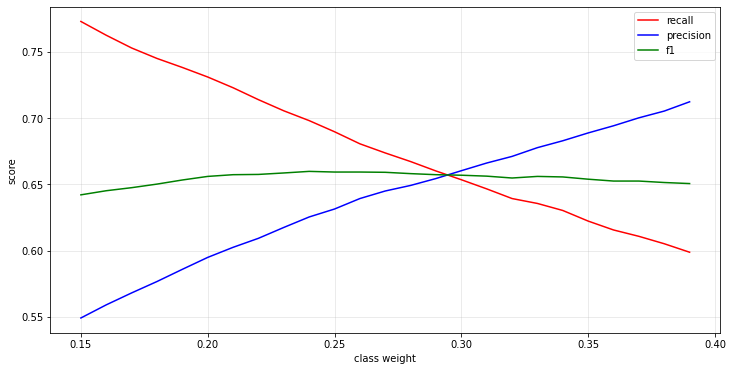

In [24]:
plot_scores(results)

In [25]:
vectorizer = best_vectorizer
model = best_model

In [26]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)

In [27]:
pipe = make_pipeline(
    preprocessing,
    model
)

pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(max_features=20000,
                                                                                   min_df=3))]),
                                                  'text')])),
                ('linearsvc', LinearSVC(class_weight={0: 0.24, 1: 0.76}))])

In [28]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('pipeline',
                                    Pipeline(steps=[('tfidfvectorizer',
                                                     TfidfVectorizer(max_features=20000,
                                                                     min_df=3))]),
                                    'text')])),
  ('linearsvc', LinearSVC(class_weight={0: 0.24, 1: 0.76}))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('tfidfvectorizer',
                                                   TfidfVectorizer(max_features=20000,
                                                                   min_df=3))]),
                                  'text')]),
 'linearsvc': LinearSVC(class_weight={0: 0.24, 1: 0.76}),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,

In [29]:
#X_train = pd.DataFrame(data=X_train, columns=['text'])
#X_test = pd.DataFrame(data=X_test, columns=['text'])

In [30]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)

In [31]:
scores(cv_results)

{'accuracy': 0.9131,
 'precision': 0.6225,
 'recall': 0.6941,
 'f1': 0.6564,
 'time': 7.0}

In [32]:
pipe.fit(X_train, y_train);

In [33]:
y_pred = pipe.predict(X_test)

Recall: 0.698
Precision: 0.625
Accuracy: 0.915
F1-score: 0.659


(0.698, 0.625, 0.915, 0.659)

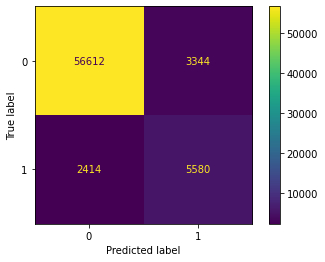

In [34]:
conf_mx_all(y_test, y_pred)

In [35]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(5, 11),
    'linearsvc__C': np.arange(0.8, 1.3, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.17, 0.24, 0.01)]
    
}

In [36]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(5, 11),
    'linearsvc__C': np.arange(0.9, 1.2, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.18, 0.24, 0.01)],
    'linearsvc__dual': [False]
}

In [37]:
search = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring='f1')

In [38]:
%%time
#search.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.78 µs


In [39]:
#search.best_params_

In [40]:
#best_estimator = search.best_estimator_

In [41]:
#y_pred = best_estimator.predict(X_test)

In [42]:
#y_train.sum()

In [43]:
#y_train.mean()

In [44]:
#conf_mx_all(y_test, y_pred)

In [45]:
#lista = ['you fucking retard', 'asshole', 'stupid bitch', 'hello!',
#        "ns he can use and practice with. I can't say much more coz I don't have more space. Retard. This is all we need an Australian version of 1 Direction.... my dick was bleeding from how hard I was masturbating to this",
#        ]
#lista = pd.DataFrame(data=lista, columns=['text'])

#best_estimator.predict(lista)

In [46]:
X_train_vec = best_vectorizer.fit_transform(X_train['text'])
X_test_vec = best_vectorizer.transform(X_test['text'])

In [47]:
def tune_threshold(C=1):
    score_results = {'class_weight': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    
    def scores2(cv_results, class_weight):
        score_results = {'class_weight': None, 'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
        for key in score_results.keys():
            if key == 'class_weight':
                score_results[key] = class_weight
            elif key == 'time':
                score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
            else:
                score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
        return score_results
    
    for class_weight in np.arange(0.05, 0.3, 0.05):
        print(class_weight)
        
        cv_results = cross_validate(LinearSVC(C=C, class_weight={0:class_weight, 1:1-class_weight}),
                                    X_train_vec, y_train, cv=5, n_jobs=-1,
                                    scoring=['accuracy', 'precision', 'recall', 'f1'])

        score_results_new = scores2(cv_results, class_weight)
        
        for key in score_results.keys():
            score_results[key].append(score_results_new[key])
            
        
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    return score_results

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.8219, 0.8766, 0.8974, 0.9082, 0.9142],
 'precision': [0.3924, 0.4904, 0.5511, 0.5956, 0.6298],
 'recall': [0.8925, 0.8199, 0.7672, 0.7247, 0.6846],
 'f1': [0.5452, 0.6137, 0.6414, 0.6539, 0.6561],
 'time': [2.0, 1.5, 1.5, 1.4, 1.3]}

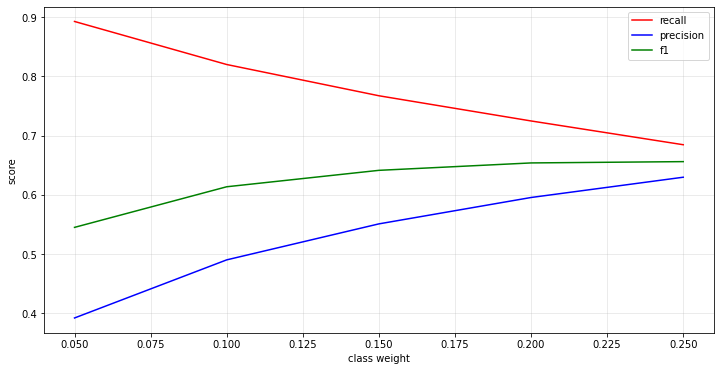

In [48]:
tune_threshold()

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.7764, 0.8743, 0.9011, 0.9142, 0.92],
 'precision': [0.3407, 0.4852, 0.5632, 0.6224, 0.6644],
 'recall': [0.9304, 0.84, 0.7718, 0.719, 0.6697],
 'f1': [0.4988, 0.6151, 0.6512, 0.6672, 0.667],
 'time': [0.9, 0.8, 0.8, 0.9, 0.8]}

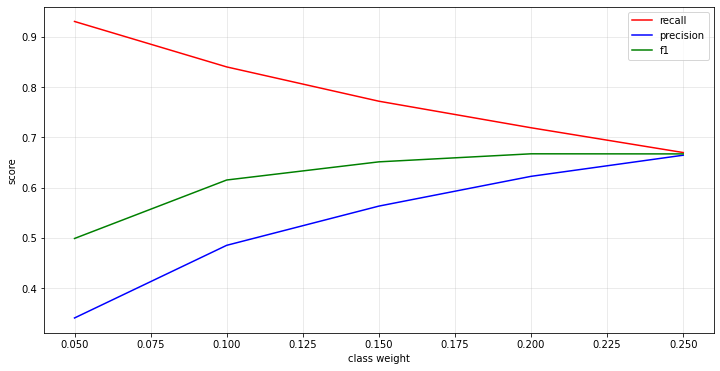

In [49]:
tune_threshold(C=0.25)

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.8052, 0.8766, 0.9001, 0.9115, 0.9178],
 'precision': [0.3716, 0.4905, 0.5597, 0.609, 0.6488],
 'recall': [0.9105, 0.8316, 0.7726, 0.7254, 0.6816],
 'f1': [0.5278, 0.6171, 0.6492, 0.6621, 0.6648],
 'time': [1.4, 1.3, 1.1, 1.0, 1.0]}

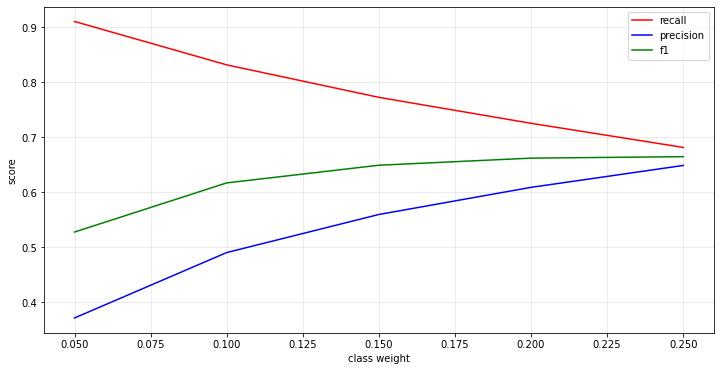

In [50]:
tune_threshold(C=0.5)

0.05
0.1
0.15000000000000002
0.2
0.25


{'class_weight': [0.05, 0.1, 0.15000000000000002, 0.2, 0.25],
 'accuracy': [0.8158, 0.877, 0.8987, 0.9097, 0.9158],
 'precision': [0.3846, 0.4915, 0.5552, 0.6016, 0.6379],
 'recall': [0.9009, 0.8263, 0.7703, 0.7258, 0.6838],
 'f1': [0.5391, 0.6164, 0.6453, 0.6579, 0.6601],
 'time': [1.6, 1.4, 1.3, 1.2, 1.3]}

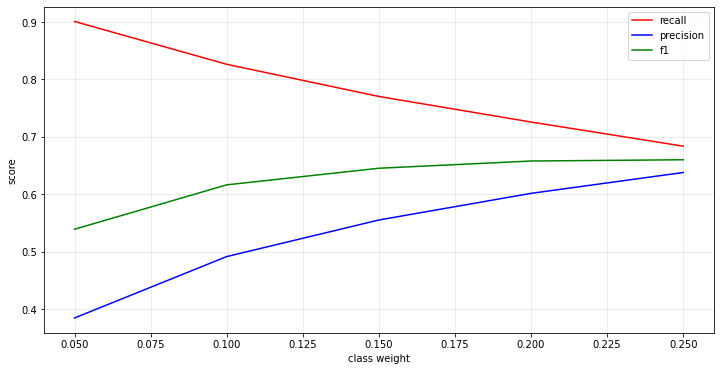

In [51]:
tune_threshold(C=0.75)

# ESTE ES EL MODELO QUE VAMOS A USAR

In [178]:
from sklearn.calibration import CalibratedClassifierCV

In [175]:
min_df = 3
max_df = 1.0
max_features = None

vectorizer = TfidfVectorizer(min_df=min_df,
                             max_df=max_df,
                             max_features=max_features)

In [182]:
C = 1
penalty = 'l1'
loss = 'squared_hinge'
dual = False
class_weight_0 = 0.22
class_weight = {0:class_weight_0, 1:1-class_weight_0}

model_svc = LinearSVC(C=C,
                  class_weight=class_weight,
                  penalty=penalty,
                  loss=loss,
                  dual=dual)

model = model_svc
#model = CalibratedClassifierCV(model_svc)

In [183]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)


pipe = make_pipeline(
    preprocessing,
    model
)

pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(min_df=3))]),
                                                  'text')])),
                ('linearsvc',
                 LinearSVC(C=1, class_weight={0: 0.22, 1: 0.78}, dual=False,
                           penalty='l1'))])

Recall: 0.724
Precision: 0.636
Accuracy: 0.919
F1-score: 0.677
CPU times: user 15.3 s, sys: 77.6 ms, total: 15.4 s
Wall time: 15.4 s


(0.724, 0.636, 0.919, 0.677)

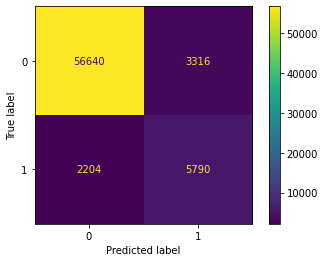

In [184]:
%%time

pipe.fit(X_train, y_train);

y_pred = pipe.predict(X_test)

conf_mx_all(y_test, y_pred)

In [157]:
pipe.steps

[('columntransformer',
  ColumnTransformer(transformers=[('pipeline',
                                   Pipeline(steps=[('tfidfvectorizer',
                                                    TfidfVectorizer(min_df=3))]),
                                   'text')])),
 ('linearsvc',
  LinearSVC(C=1, class_weight={0: 0.22, 1: 0.78}, dual=False, penalty='l1'))]

In [134]:
pipe.steps[:-1][0][1].transform(X_test)

<67950x51802 sparse matrix of type '<class 'numpy.float64'>'
	with 1734542 stored elements in Compressed Sparse Row format>

In [ ]:
def pipe_predict_proba(pipe, X_test):
    

In [56]:
new_df = pd.DataFrame({'text': X_test['text'], 'test': y_test, 'pred': y_pred})
new_df[(new_df['test'] + new_df['pred'])==1]

,text,test,pred
93663,script assisted fucking grumble yeah know us l...,1.0,0.0
89140,stalking harassment call chzz deletes contribu...,1.0,0.0
222916,juxtaposition jaguar pitch joan evening fuckin...,0.0,1.0
186817,nice completely ignored main thing whereas che...,1.0,0.0
194091,pr team lair sas stinks ha,0.0,1.0
...,...,...,...
39389,look oh gosh actually complaining yesterday in...,0.0,1.0
68876,interesting stupid strange interesting william...,1.0,0.0
214106,shaner ahem pens fan appreciate system rewards...,1.0,0.0
149887,poor theories,1.0,0.0


In [57]:
cv_results = cross_validate(model, X_train_vec, y_train, cv=5, n_jobs=-1, scoring=scoring)
cv_results

{'fit_time': array([3.92180419, 3.91841841, 3.81030941, 3.88249016, 3.85729194]),
 'score_time': array([0.03616023, 0.04164863, 0.05556202, 0.04981256, 0.03998208]),
 'test_accuracy': array([0.91573636, 0.913655  , 0.91485067, 0.91459838, 0.91567063]),
 'test_precision': array([0.63023256, 0.62092703, 0.626097  , 0.62488479, 0.63122066]),
 'test_recall': array([0.71466245, 0.71360759, 0.71492616, 0.71518987, 0.70912447]),
 'test_f1': array([0.66979733, 0.66404908, 0.66756956, 0.66699459, 0.66790859])}

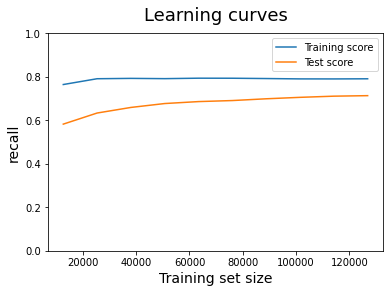

In [58]:
from sklearn.model_selection import learning_curve


train_sizes = np.linspace(.1,  1, 10)
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=X_train_vec, y=y_train, train_sizes=train_sizes, cv=5, scoring='recall')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('recall', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.ylim(0, 1)
plt.legend();

# Package

In [135]:
from cyberbullying.models import MLModel

In [192]:
package_model = MLModel(min_df=min_df, max_df=max_df, max_features=max_features,
                        C=1, class_weight_0=class_weight_0, penalty=penalty, loss=loss, dual=dual)

In [193]:
package_model.set_pipeline()

In [194]:
package_model.train(X_train, y_train)

In [195]:
y_pred = package_model.predict(X_test)

In [196]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

Recall: 0.724
Precision: 0.636
Accuracy: 0.919
F1-score: 0.677


(0.724, 0.636, 0.919, 0.677)

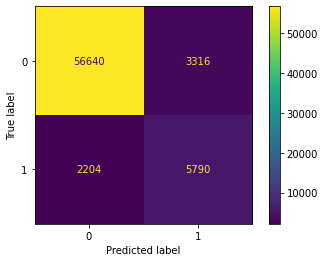

In [197]:
conf_mx_all(y_test, y_pred)

In [198]:
y_predict_proba = package_model.predict_proba(X_test)

In [199]:
y_predict_proba[0]

array([0.58504091, 0.41495909])

# TUNNING

In [59]:
vectorizer = TfidfVectorizer(min_df=3,
                             max_df=1.0,
                             max_features=20000)

In [107]:
class_weight_0 = 0.22
class_weight = {0:class_weight_0, 1:1-class_weight_0}

model = LinearSVC(C=1,
                  class_weight=class_weight,
                  penalty='l1',
                  loss='squared_hinge',
                  dual=False)



class_weight_0 = 0.15
class_weight = {0:class_weight_0, 1:1-class_weight_0}

model2 = LinearSVC(C=1,
                  class_weight=class_weight,
                  penalty='l1',
                  loss='squared_hinge',
                  dual=False)


class_weight_0 = 0.4
class_weight = {0:class_weight_0, 1:1-class_weight_0}

model3 = LinearSVC(C=1,
                  class_weight=class_weight,
                  penalty='l1',
                  loss='squared_hinge',
                  dual=False)

In [108]:
from sklearn.linear_model import LogisticRegression

In [109]:
#model2 = LogisticRegression(max_iter=10000, class_weight=class_weight, penalty='l2')

In [113]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators = [("svc", model),("svc2", model2),("svc3", model3)],
    voting = 'hard', # to use predict_proba of each classifier before voting
    weights = [1,1,1] # to equally weight forest and logreg in the vote
)

In [114]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)


pipe = make_pipeline(
    preprocessing,
    ensemble
)

pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(max_features=20000,
                                                                                   min_df=3))]),
                                                  'text')])),
                ('votingclassifier',
                 VotingClassifier(estimators=[('svc',
                                               LinearSVC(C=1,
                                                         class_weight={0: 0.22,
                                                                       1: 0.78},
                                                         dual=False,
                                                         penalty='l1')),
                                              ('svc2',
                                               LinearSVC(C=1,
                                                         class_weight={0: 0.15,
                                                                       1: 0.85},
                                                         dual=False,
                                                         penalty='l1')),
                                              ('svc3',
                                               LinearSVC(C=1,
                                                         class_weight={0: 0.4,
                                                                       1: 0.6},
                                                         dual=False,
                                                         penalty='l1'))],
                                  weights=[1, 1, 1]))])

Recall: 0.719
Precision: 0.628
Accuracy: 0.917
F1-score: 0.67
CPU times: user 14.1 s, sys: 48.8 ms, total: 14.2 s
Wall time: 14.2 s


(0.719, 0.628, 0.917, 0.67)

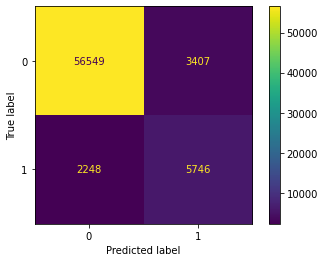

In [115]:
%%time

pipe.fit(X_train, y_train);

y_pred = pipe.predict(X_test)

conf_mx_all(y_test, y_pred)

In [66]:
new_df = pd.DataFrame({'text': X_test['text'], 'test': y_test, 'pred': y_pred})
new_df[(new_df['test'] + new_df['pred'])==1]

,text,test,pred
93663,script assisted fucking grumble yeah know us l...,1.0,0.0
68501,protect page gon na kill user page tomorrow mo...,1.0,0.0
222916,juxtaposition jaguar pitch joan evening fuckin...,0.0,1.0
186817,nice completely ignored main thing whereas che...,1.0,0.0
194091,pr team lair sas stinks ha,0.0,1.0
...,...,...,...
39389,look oh gosh actually complaining yesterday in...,0.0,1.0
68876,interesting stupid strange interesting william...,1.0,0.0
214106,shaner ahem pens fan appreciate system rewards...,1.0,0.0
149887,poor theories,1.0,0.0


In [67]:
cv_results = cross_validate(model, X_train_vec, y_train, cv=5, n_jobs=-1, scoring=scoring)
cv_results

{'fit_time': array([3.98487091, 3.44664192, 3.33751941, 3.37145472, 3.46618676]),
 'score_time': array([0.03467917, 0.03454447, 0.0539577 , 0.04239821, 0.03208971]),
 'test_accuracy': array([0.9157679 , 0.91368653, 0.91485067, 0.91459838, 0.91567063]),
 'test_precision': array([0.63037916, 0.62101399, 0.626097  , 0.62488479, 0.63122066]),
 'test_recall': array([0.71466245, 0.71387131, 0.71492616, 0.71518987, 0.70912447]),
 'test_f1': array([0.66988011, 0.66421298, 0.66756956, 0.66699459, 0.66790859])}

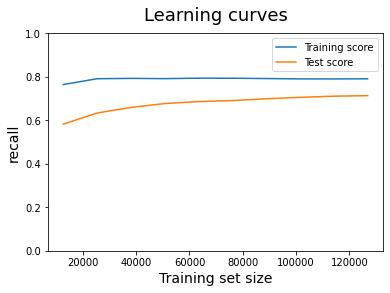

In [68]:
from sklearn.model_selection import learning_curve


train_sizes = np.linspace(.1,  1, 10)
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=X_train_vec, y=y_train, train_sizes=train_sizes, cv=5, scoring='recall')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('recall', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.ylim(0, 1)
plt.legend();

# Prueba nueva función de predict 

In [69]:
import math

In [70]:
def slicing_input(text):
    n=20
    words_list = text.split(" ")
    subdivisions = []
    coef = math.ceil(len(words_list)/n)
    for i in range(coef):
            subdivisions.append(" ".join(words_list[i*n:(i+1)*n]))
    return subdivisions

In [71]:
X_test['text'].map(lambda text: len(text.split())).sort_values(ascending=False)[0:10]

80955     712
55070     680
57940     642
166842    634
122427    626
37439     622
117130    617
110821    612
195071    601
177829    592
Name: text, dtype: int64

In [72]:
#index = 195358

#word_1 = X_test.loc[index, 'text']

word_1 = "There are so many things that are incorrect with your comment it's unbelievable. Guns don't kill people. A gun doesn't get up off a table and then shoot someone. He's not the reason soldiers are at war he's merely showing us weapons and explaining how they work and whether he likes them or not. You blame him for violent video games...Why would this guy mess around with video games when he has real weapons he can use and practice with. I can't say much more coz I don't have more space. Retard. This is all we need an Australian version of 1 Direction.... my dick was bleeding from how hard I was masturbating to this"


word_1 = slicing_input(word_1)
word_1

["There are so many things that are incorrect with your comment it's unbelievable. Guns don't kill people. A gun doesn't",
 "get up off a table and then shoot someone. He's not the reason soldiers are at war he's merely showing",
 'us weapons and explaining how they work and whether he likes them or not. You blame him for violent video',
 'games...Why would this guy mess around with video games when he has real weapons he can use and practice with.',
 "I can't say much more coz I don't have more space. Retard. This is all we need an Australian version",
 'of 1 Direction.... my dick was bleeding from how hard I was masturbating to this']

In [73]:
#y_test[index]

In [74]:
word_1_df = pd.DataFrame({'text': word_1})
word_1_df

,text
0,There are so many things that are incorrect wi...
1,get up off a table and then shoot someone. He'...
2,us weapons and explaining how they work and wh...
3,games...Why would this guy mess around with vi...
4,I can't say much more coz I don't have more sp...
5,of 1 Direction.... my dick was bleeding from h...


In [75]:
pipe.predict(word_1_df)

array([0., 0., 0., 0., 0., 1.])

In [76]:
prueba = pd.DataFrame({'text':X_train['text'], 'target':y_train})
prueba_0 = prueba[prueba['target']==0]
prueba_0_ = prueba_0

In [77]:
X_train_prueba = prueba_0[['text']]

In [78]:
def predict_slicing_input(text):
    n=100
    words_list = text.split(" ")
    subdivisions = []
    coef = math.ceil(len(words_list)/n)
    for i in range(coef):
            subdivisions.append(" ".join(words_list[i*n:(i+1)*n]))
    
    subdivisions = pd.DataFrame({'text':subdivisions})
    
    predictions = pipe.predict(subdivisions).max()
    
    return predictions

In [79]:
texto = "There are so many things that are incorrect with your comment it's unbelievable. Guns don't kill people. A gun doesn't get up off a table and then shoot someone. He's not the reason soldiers are at war he's merely showing us weapons and explaining how they work and whether he likes them or not. You blame him for violent video games...Why would this guy mess around with video games when he has real weapons he can use and practice with. I can't say much more coz I don't have more space. Retard. This is all we need an Australian version of 1 Direction.... my dick was bleeding from how hard I was masturbating to this"

In [80]:
predict_slicing_input(texto)

1.0

In [81]:
suma = []
#for texto in prueba_0_['text']:
#    suma.append(predict_slicing_input(texto))

In [82]:
#sum(suma)

In [83]:
#pd.DataFrame({'text':prueba_0['text'], 'target': prueba_0['target'], 'y_pred':suma})

In [84]:
#sum(suma)

In [85]:
#pipe.predict(X_train_prueba).sum()

In [86]:
def predict_slicing_df(X_test):
    x = X_test['text']
    y_pred = []
    for text in x:
        y_pred.append(predict_slicing_input(text))
    return y_pred

In [87]:
#y_pred_3 = predict_slicing_df(X_test)

In [88]:
#conf_mx_all(y_test, y_pred_3)

# Prueba con otro dataset

In [89]:
df_test = pd.read_csv('../../raw_data/twitter_parsed_dataset.csv', usecols=['Text', 'oh_label'])
df_test = df_test.rename(columns={'Text': 'text', 'oh_label': 'target'})
df_test.head()

,text,target
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0


In [90]:
df_test.shape

(16851, 2)

In [91]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [92]:
def clean_data(text,
               remove_punctuation=True,
               lower_text=True,
               remove_numbers=True,
               remove_stopwords=False, 
               lemmatize=False):
    
    text = str(text)
    
    # replace emojis with text
    #text = demoji.replace_with_desc(text, ' ')
    
    # keep only letters
    if remove_punctuation:
        text = re.sub(r'[^a-zA-Z]+', ' ', text)
    
    # remove punctuation
    #if remove_punctuation:
    #    for punctuation in string.punctuation:
    #        text = text.replace(punctuation, ' ')
    
    # lower text
    if lower_text:
        text = text.lower()
    
    # remove numbers
    if remove_numbers:
        text = ''.join([w for w in text if not w.isdigit()])
    
    # remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text = ' '.join([w for w in word_tokens if not w in stop_words])
    
    # lemmatize
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        text = ''.join([lemmatizer.lemmatize(word) for word in text]) # no entiendo por qué no va un espacio
    
    text = text.strip()
    
    return text


def clean_df(df, 
            remove_punctuation=True,
            lower_text=True,
            remove_numbers=True,
            remove_stopwords=False, 
            lemmatize=False):
    
    df = df.copy()
    
    df = df.drop_duplicates()
    
    df['text'] = df['text'].apply(lambda text: clean_data(text,
                                                          remove_punctuation,
                                                          lower_text,
                                                          remove_numbers,
                                                          remove_stopwords,
                                                          lemmatize))
    
    df = df.drop_duplicates()
    
    df = df.replace(['', ' '], np.nan)
    df = df.dropna().reset_index(drop=True)
    
    return df

In [93]:
%%time
#df_test = clean_df(df_test, remove_punctuation=True, lower_text=True, remove_numbers=True, remove_stopwords=True, lemmatize=True)
#df_test.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


In [94]:
#df_test = df_test[df_test['text'].map(lambda text: len(text.split())) < 1000]

In [95]:
#df_test['text'] = df_test['text'].map(simple_spam)

In [96]:
#df_test['text'] = df_test['text'].map(double_spam)

In [97]:
#df_test.shape

In [98]:
#X_test_2 = df_test[['text']]
#y_test_2 = df_test['target']

In [99]:
#y_pred_2 = pipe.predict(X_test_2)

In [100]:
#y_pred_2

In [101]:
#conf_mx_all(y_test_2, y_pred_2)

In [102]:
#new_df_2 = pd.DataFrame({'text': X_test_2['text'], 'test': y_test_2, 'pred': y_pred_2})
#new_df_2[(new_df_2['test'] + new_df_2['pred'])==1]

# FIN DEL MODELO 

In [103]:
def best_threshold(thresholds_list,model,x_test,y_test, y_pred):
    recalls=[]
    accuracies=[]
    precisions=[]
    F1_scores=[]
    for threshold in thresholds:
        y_pred=threshold_modifier(model,x_test,threshold)
        cm = confusion_matrix(y_test, y_pred)
        recall, precision, accuracy,F1_score=conf_mx_all(y_test, y_pred)
        recalls.append(recall)
        accuracies.append(accuracy)
        precisions.append(precision)
        F1_scores.append(F1_score)     

    metrics={'thresholds': thresholds,'recall':recalls, 'accuracy': accuracies, 'precision':precisions,'F1_score':F1_scores}
    return metrics

In [104]:
def threshold_modifier(model,xtest,threshold):
    ypred=model._predict_proba_lr(xtest)[:,1]>threshold
    ypred=ypred.astype(int)
    return ypred

In [105]:
model._predict_proba_lr(X_test_vec)

NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
thresholds= np.arange(0.1, 0.9, 0.05)
thres = best_threshold(thresholds, model, X_test_vec, y_test, y_pred)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(thresholds, thres['recall'], label='recall')
plt.plot(thresholds, thres['accuracy'], label='accuracy')
plt.plot(thresholds, thres['precision'], label='precision')
plt.plot(thresholds, thres['F1_score'], label='F1_score')
plt.grid(alpha=0.3)
plt.legend();

In [ ]:
X_train_vec

In [ ]:
tune_threshold(C=1)

In [ ]:
%%time
cv_results = cross_validate(LinearSVC(class_weight={0:.1, 1:.9}), X_train_vec, y_train, cv=5, n_jobs=-1,
                            scoring=['accuracy', 'precision', 'recall', 'f1'])

In [ ]:
scores(cv_results)

In [ ]:
2=1

In [ ]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
#plt.text(9.2, 1, textstr, fontsize=14,
#        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [ ]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

In [ ]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
#plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

## Tunning Hyperparameters

In [ ]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print(f"Best Parameters: {grid_fit.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, best_predictions):.4f}")
    print(f"F1-score: {f1_score(y_test, best_predictions):.4f}")
    print(f"Precision: {precision_score(y_test, best_predictions):.4f}")
    print(f"Recall: {recall_score(y_test, best_predictions):.4f}")
    
    return best_clf

In [ ]:
%%time
# Linear SVC
param_grid = {
    'C': [0.25, 0.5, 0.75, 1]
}

clf_linsvc = LinearSVC(max_iter=10000, dual=True)

best_clf_linsvc = param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)

In [ ]:
X_train_vec

In [ ]:
results_tunned = {'Model':[], 'Best Parameters':[], 'Accuracy':[], 'F1-score':[], 'Precision':[], 'Recall':[]}

for model in [best_clf_sgd, best_clf_linsvc]:
    best_predictions = model.predict(X_test_vec)
    results_tunned['Model'].append(model.__class__.__name__)
    results_tunned["Best Parameters"].append(model.get_params())
    results_tunned["Accuracy"].append(accuracy_score(y_test, best_predictions))
    results_tunned["F1-score"].append(f1_score(y_test, best_predictions))
    results_tunned["Precision"].append(precision_score(y_test, best_predictions))
    results_tunned["Recall"].append(recall_score(y_test, best_predictions))

#results_tunned
results_tunned = pd.DataFrame(results_tunned).sort_values(by = 'F1-score', ascending = False)
results_tunned